Notebook for a mocked up GRB orphan afterlow lightcurve. 

Fast rise :
1 mag in 2 day rise
Reasonably fast decline :
2 mag in 10 day decline 

Pick 22.5 as a typical peak mag. Say z~1-2 (all data above are estimates from Nial Tanvir)

Fairly flat colours. 


Require : 6 points total and 1 night all 4 filters 

Summary - if we  Requesting 4 filters on rise AND decline == zero efficiency

If we requesting 4 filters at some stage gives ~4 percent efficiency 

Typical sky density is 

1 per 1000 dq dg 

therefore about 

18 per yr 

And with these efficiencies we are likely to detect < 1 object per yr. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db

In [2]:
year = 9

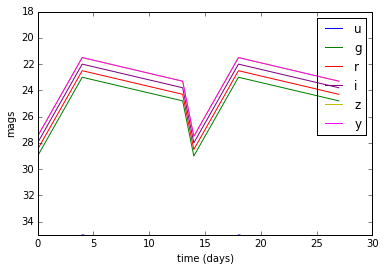

In [3]:
# Trying to make an orphan GRB-like light curve
peaks = {'uPeak':35, 'gPeak':23., 'rPeak':22.5, 'iPeak':22., 'zPeak':21.5,'yPeak':21.5}

colors = ['b','g','r','purple','y','magenta','k']
filterNames = ['u','g','r','i','z','y']

peakTime = 4.
transDuration = peakTime+10. # Days
transMetric = metrics.TransientMetric(riseSlope= -1.5, declineSlope=0.2, 
                                      transDuration=transDuration, peakTime=peakTime, surveyDuration=1, **peaks)


times = np.arange(0.,transDuration*2,1) 
for filterName, color in zip(filterNames,colors):
    filters = np.array([filterName]*times.size)
    lc = transMetric.lightCurve(times % transDuration,filters)
    plt.plot(times,lc, color, label=filterName)
plt.xlabel('time (days)')
plt.ylabel('mags')
plt.ylim([35,18])
plt.legend()

In [4]:
# Pick a slicer
slicer = slicers.HealpixSlicer(nside=64)

summaryMetrics = [metrics.MedianMetric()]
# Configure some metrics
metricList = []
# What fraction of 60-day, r=20 mag flat transients are detected at least once?
metricList.append(transMetric)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [8]:
# Set the database and query
runName = 'enigma_1189'
sqlconstraint = 'night between %f and %f' % ((365.25*year,365.25*(year+1)))
bDict={}
for i,metric in enumerate(metricList):
    bDict[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                          runName=runName, summaryMetrics=summaryMetrics)

Querying database with constraint night between 3287.250000 and 3652.500000
Found 231251 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting.
monopole: 0.474932  dipole: lon: 99.3833, lat: -15.8725, amp: 0.0893333
Plotting complete.


/Users/lynnej/anaconda/lib/python2.7/site-packages/sqlalchemy/sql/elements.py:3738: SAWarning: Textual SQL expression 'night between 3287.250000...' should be explicitly declared as text('night between 3287.250000...') (this warning may be suppressed after 10 occurrences)
  {"expr": util.ellipses_string(element)})


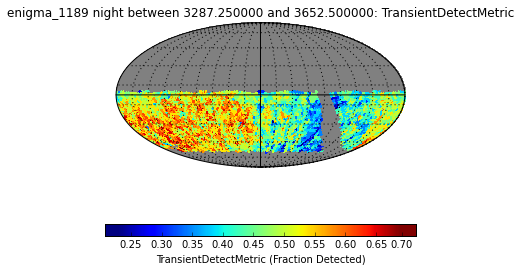

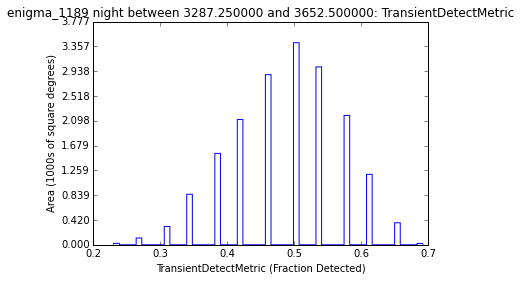

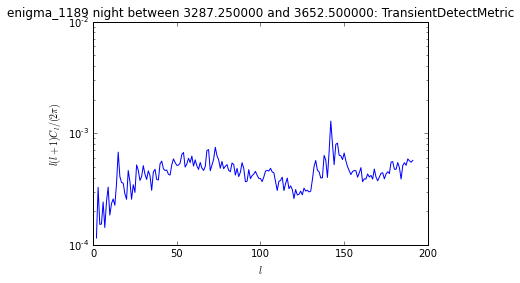

In [9]:
opsdb = db.OpsimDatabase(runName + '_sqlite.db')
outDir = 'Transients'
resultsDb = db.ResultsDb(outDir=outDir)

bgroup = metricBundles.MetricBundleGroup(bDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [15]:
for key in bDict:
    bDict[key].computeSummaryStats(resultsDb=resultsDb)
    print bDict[key].metric.name, bDict[key].summaryValues

TransientDetectMetric {'Median': 0.57692307692307687}


In [18]:

transMetric = metrics.TransientMetric(riseSlope= -1.5, declineSlope=0.2, 
                                      transDuration=transDuration, peakTime=peakTime, surveyDuration=1, 
                                      nFilters=4, nPrePeak=2, nPerLC=1, **peaks)

sqlconstraint = 'night between %f and %f' % (365.25*year,365.25*(year+1))
transBundle = metricBundles.MetricBundle(transMetric, slicer, sqlconstraint, 
                                          runName=runName, summaryMetrics=summaryMetrics)

Querying database with constraint night between 3287.250000 and 3652.500000
Found 240438 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting.
monopole: 0.0410363  dipole: lon: 154.997, lat: 46.1192, amp: 0.00676024
Plotting complete.


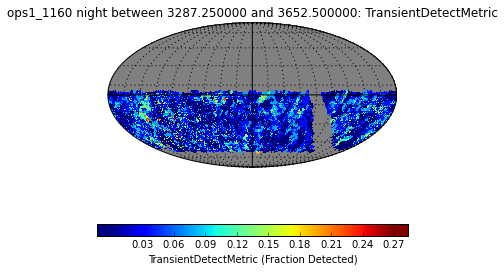

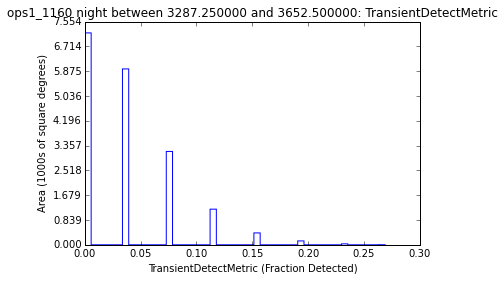

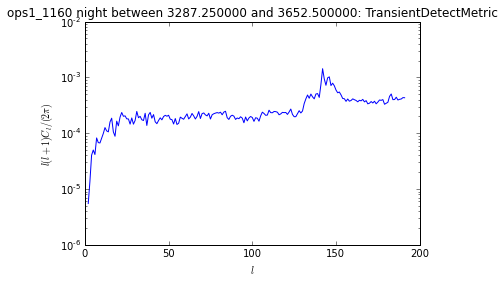

In [19]:
bgroup = metricBundles.MetricBundleGroup({0:transBundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)


In [20]:
transBundle.summaryValues

{'Median': 0.038461538461538464}

Looks like trying to get lots of color info kills it.  Some other possible things to explore:
* Getting high r-band coverage accross the curve, and then smattering in the other filters
* Would really like 4 filters in a single night.